## SVM

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
df = pd.read_csv('diabetes.csv')

#any further infos on the diabetes dataset:
#https://www.kaggle.com/uciml/pima-indians-diabetes-database

The datasets consist of several medical predictor (independent) variables and one target (dependent) variable, Outcome. Independent variables include the number of pregnancies the patient has had, their BMI, insulin level, age, and so on.

- Pregnancies:  Number of times pregnant
- Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
- BloodPressure: Diastolic blood pressure (mm Hg)
- SkinThickness: Triceps skin fold thickness (mm)
- Insulin: 2-Hour serum insulin (mu U/ml)
- BMI: Body mass index (weight in kg/(height in m)^2)
- DiabetesPedigreeFunction: Diabetes pedigree function
- Age: (years)
- Outcome


In [2]:
df.shape

(768, 9)

## Exploratory Data Analysis

In [3]:
#gives information about the data types, columns, null value counts, memory usage etc
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timespreg  768 non-null    int64  
 1   gluctol    768 non-null    int64  
 2   diaspb     768 non-null    int64  
 3   triceps    768 non-null    int64  
 4   insulin    768 non-null    int64  
 5   massindex  768 non-null    float64
 6   pedigree   768 non-null    float64
 7   age        768 non-null    int64  
 8   target     768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
df.isna().sum()

timespreg    0
gluctol      0
diaspb       0
triceps      0
insulin      0
massindex    0
pedigree     0
age          0
target       0
dtype: int64

In [5]:
#basic statistic details about the data
df.describe(include="all")

,timespreg,gluctol,diaspb,triceps,insulin,massindex,pedigree,age,target
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


<Axes: >

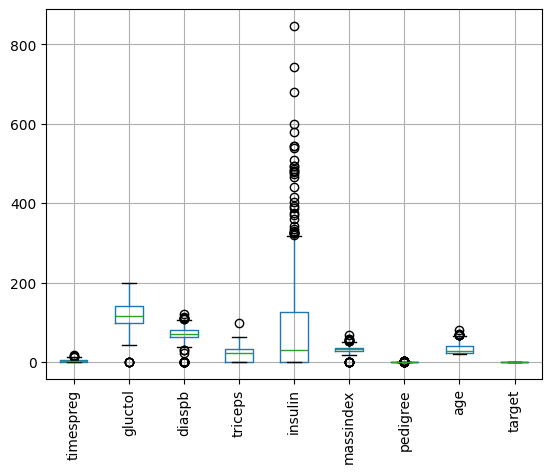

In [6]:
%matplotlib inline
df.boxplot(rot=90)

array([[<Axes: title={'center': 'timespreg'}>,
        <Axes: title={'center': 'gluctol'}>,
        <Axes: title={'center': 'diaspb'}>],
       [<Axes: title={'center': 'triceps'}>,
        <Axes: title={'center': 'insulin'}>,
        <Axes: title={'center': 'massindex'}>],
       [<Axes: title={'center': 'pedigree'}>,
        <Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'target'}>]], dtype=object)

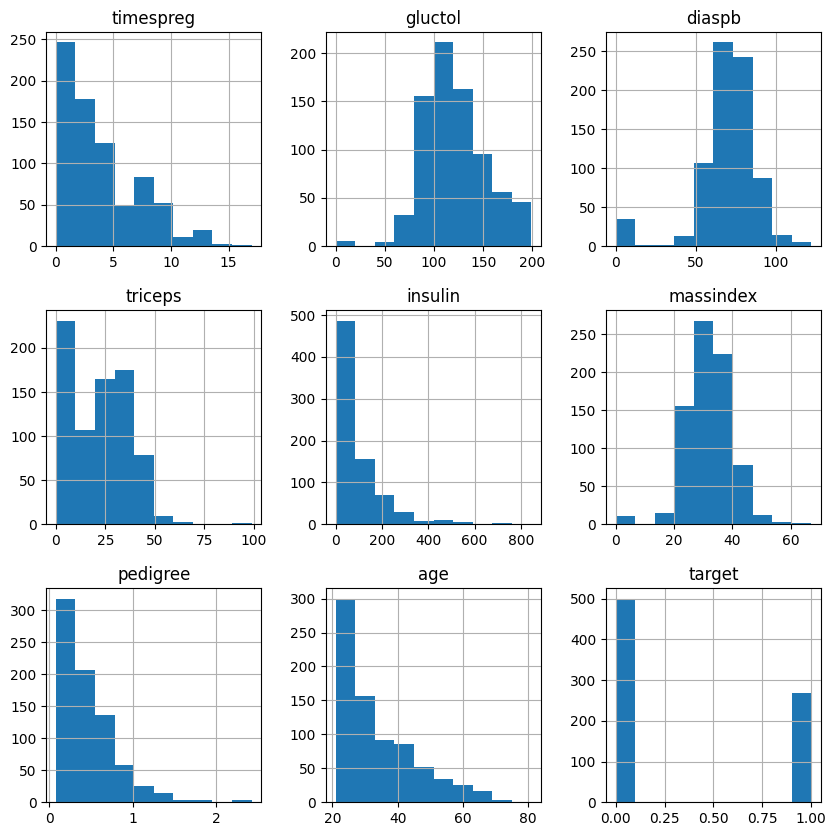

In [7]:
df.hist(figsize=(10,10))

target
0    500
1    268
dtype: int64


<Axes: title={'center': 'Distribution of target'}, xlabel='target'>

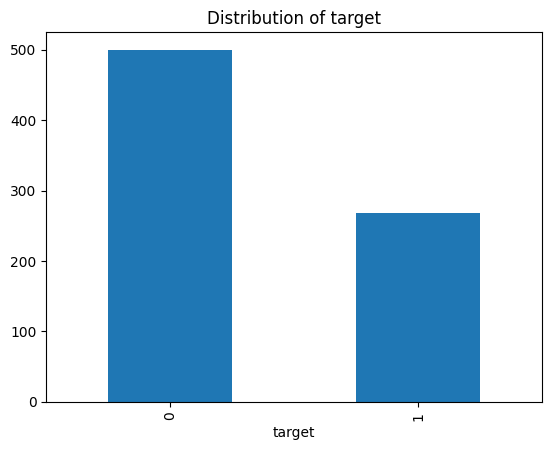

In [8]:
#Print class freq. through pandas: we group the data by the column target and we count the number of rows
target_dist=df.groupby('target').size()
print(target_dist)

#some imports to plot
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Visualize Class Counts
target_dist.plot.bar(x='',y='',title='Distribution of target')

## Data Preparation

### Separate Train/Test sets

In [9]:
#Separate X and y (explanatory variables and target variable)
X = df.iloc[:,:-1]
y = df.iloc[:,-1] #[-1]]

#X.head()
y.head()

0    1
1    0
2    1
3    0
4    1
Name: target, dtype: int64

In [10]:
from sklearn.model_selection import train_test_split

#SPLIT DATA INTO TRAIN AND TEST SET
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size =0.30, #by default is 75%-25%
                                                    #shuffle is set True by default,
                                                    stratify=y,
                                                    random_state= 123
                                                   ) #fix random seed for replicability

print(X_train.shape,X_test.shape)

(537, 8) (231, 8)


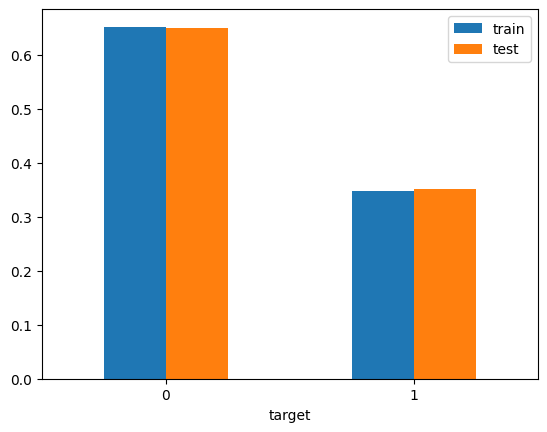

In [11]:
y_train_dist=y_train.groupby(y_train.iloc[:]).size()/y_train.size
y_test_dist=y_test.groupby(y_test.iloc[:]).size()/y_test.size

train_test_dist = pd.DataFrame({'train': y_train_dist, 'test': y_test_dist})
ax = train_test_dist.plot.bar(rot=0) # rotation of the labels

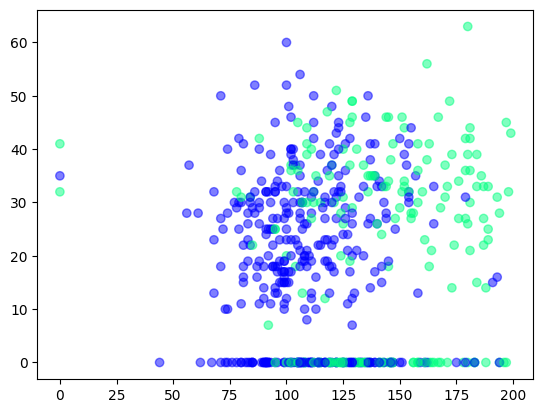

In [12]:
import matplotlib.pyplot as plt

x1 = X_train.iloc[:,1]
x2 = X_train.iloc[:,3]

plt.scatter(x1, x2,alpha=0.5, c=y_train, cmap='winter')
plt.show()

# 4- SVM


![SVM](SVM.png)

We aim to resolve the following optimization problem:

\begin{align}\begin{aligned}\min_ {w, b, d} \frac{1}{2} ||w||^2 + C \sum_{i=1}^{m} d_i\\\begin{split}\textrm {subject to } & y_i (w^T \phi (x_i) - b) \geq 1 - d_i,\\
& d_i \geq 0\end{split}\end{aligned}\end{align}

where $\phi$ is the kernel map that can be chosen as 
 - linear: $\langle x, x'\rangle$
 - polynomial: $(\gamma \langle x, x'\rangle + r)^d$ where $\gamma,\, d ,\, r$ are specified by keyword gamma, degree and coef0 respectively.
 - radial basis function rbf: $\exp(-\gamma \|x-x'\|^2)$
 - neural networks (sigmoid): $\tanh(\gamma \langle x,x'\rangle + r)$
 
![Kernel](kernels.png)

We aim to resolve the following optimization problem:

\begin{align}\begin{aligned}\min_ {w, b, d} \frac{1}{2} ||w||^2 + C \sum_{i=1}^{m} d_i\\\begin{split}\textrm {subject to } & y_i (w^T \phi (x_i) - b) \geq 1 - d_i,\\
& d_i \geq 0\end{split}\end{aligned}\end{align}

where $\phi$ is the kernel map that can be chosen as
 - linear: $\langle x, x'\rangle$
 - polynomial: $(\gamma \langle x, x'\rangle + r)^d$ where $\gamma,\, d ,\, r$ are specified by keyword gamma, degree and coef0 respectively.
 - radial basis function rbf: $\exp(-\gamma \|x-x'\|^2)$
 - neural networks (sigmoid): $\tanh(\gamma \langle x,x'\rangle + r)$


In [13]:
from sklearn.svm import SVC

model = SVC(kernel='sigmoid',C=1)


# C : Penalty parameter C of the error term.
# kernel : kernel type. It must be one of ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’ or a callable. If none is given, ‘rbf’ will be used. If a callable is given it is used to pre-compute the kernel matrix from data matrices; that matrix should be an array of shape (n_samples, n_samples).
# degree : Degree of the polynomial kernel function (‘poly’)
# gamma : Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.
# coef0 : Independent term in kernel function.
# tol : Tolerance for stopping criterion.
# class_weight : Set the parameter C of class i to class_weight[i]*C for SVC.

In [14]:
# Scale data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X)

# We compute the scaler
scaled_data = scaler.transform(X.astype(float))
scaled_X = pd.DataFrame(scaled_data.astype(float))
scaled_X.columns = X.columns

# We apply the same scaler to the data
scaled_data = scaler.transform(X_train.astype(float))
scaled_X_train = pd.DataFrame(scaled_data.astype(float))
scaled_X_train.columns = X_train.columns

scaled_data = scaler.transform(X_test.astype(float))
scaled_X_test = pd.DataFrame(scaled_data.astype(float))
scaled_X_test.columns = X_test.columns

In [15]:
model.fit(scaled_X_train, y_train)
model.predict(scaled_X_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0], dtype=int64)

In [16]:
#DEFINE YOUR CLASSIFIER and THE PARAMETERS GRID
from sklearn.svm import SVC

classifier = SVC()
parameters = {
    "kernel": ['linear', 'rbf', 'poly'],  # 'poly' instead of 'polinomial'
    "C": [.01, .1, 1],
    "gamma": [1],
    "degree": [2, 3, 4]  # This is only used with 'poly' kernel
}

In [17]:
#DEFINE YOUR GRIDSEARCH
'''
GS perfoms an exhaustive search over specified parameter values for an estimator.
GS uses a Stratified K-Folds cross-validator
(The folds are made by preserving the percentage of samples for each class.)
If refit=True the model is retrained on the whole training set with the best found params
'''
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(classifier, parameters, cv=3, scoring = 'f1', verbose=50, n_jobs=-1, refit=True)

In [18]:
#TRAIN YOUR CLASSIFIER
gs = gs.fit(scaled_X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


In [19]:
#summarize the results of your GRIDSEARCH
print('***GRIDSEARCH RESULTS***')

print("Best score: %f using %s" % (gs.best_score_, gs.best_params_))
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
params = gs.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

***GRIDSEARCH RESULTS***
Best score: 0.636467 using {'C': 1, 'degree': 2, 'gamma': 1, 'kernel': 'linear'}
0.580080 (0.047763) with: {'C': 0.01, 'degree': 2, 'gamma': 1, 'kernel': 'linear'}
0.000000 (0.000000) with: {'C': 0.01, 'degree': 2, 'gamma': 1, 'kernel': 'rbf'}
0.271609 (0.058743) with: {'C': 0.01, 'degree': 2, 'gamma': 1, 'kernel': 'poly'}
0.580080 (0.047763) with: {'C': 0.01, 'degree': 3, 'gamma': 1, 'kernel': 'linear'}
0.000000 (0.000000) with: {'C': 0.01, 'degree': 3, 'gamma': 1, 'kernel': 'rbf'}
0.547675 (0.018783) with: {'C': 0.01, 'degree': 3, 'gamma': 1, 'kernel': 'poly'}
0.580080 (0.047763) with: {'C': 0.01, 'degree': 4, 'gamma': 1, 'kernel': 'linear'}
0.000000 (0.000000) with: {'C': 0.01, 'degree': 4, 'gamma': 1, 'kernel': 'rbf'}
0.419662 (0.045105) with: {'C': 0.01, 'degree': 4, 'gamma': 1, 'kernel': 'poly'}
0.624749 (0.074515) with: {'C': 0.1, 'degree': 2, 'gamma': 1, 'kernel': 'linear'}
0.000000 (0.000000) with: {'C': 0.1, 'degree': 2, 'gamma': 1, 'kernel': 'rbf'}
0

In [20]:
#TEST ON YOUR TEST SET
best_model = gs.best_estimator_
y_pred = best_model.predict(scaled_X_test)

y_pred_train = best_model.predict(scaled_X_train)

In [21]:
#This is your prediction on the TEST SET
#y_pred

In [22]:
#EVALUATE YOUR PREDICTION (on the y_test that you left aside)
from sklearn.metrics import f1_score


print('***RESULTS ON TRAIN SET***')
print("f1_score: ", f1_score(y_train, y_pred_train))
print("--")
print('***RESULTS ON TEST SET***')
print("f1_score: ", f1_score(y_test, y_pred))

***RESULTS ON TRAIN SET***
f1_score:  0.6484848484848484
--
***RESULTS ON TEST SET***
f1_score:  0.5874125874125874


In [23]:
#PRINT SOME FURTHER METRICS
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.87      0.82       150
           1       0.68      0.52      0.59        81

    accuracy                           0.74       231
   macro avg       0.72      0.69      0.70       231
weighted avg       0.74      0.74      0.74       231



In [24]:
#CONFUSION MATRIX
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

[[130  20]
 [ 39  42]]


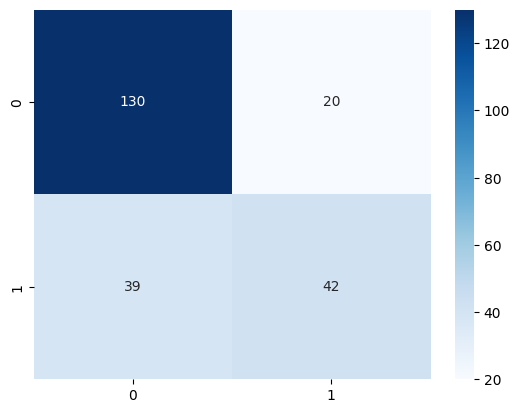

In [25]:
# Plot confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues"); #annot=True to annotate cells fmt: format


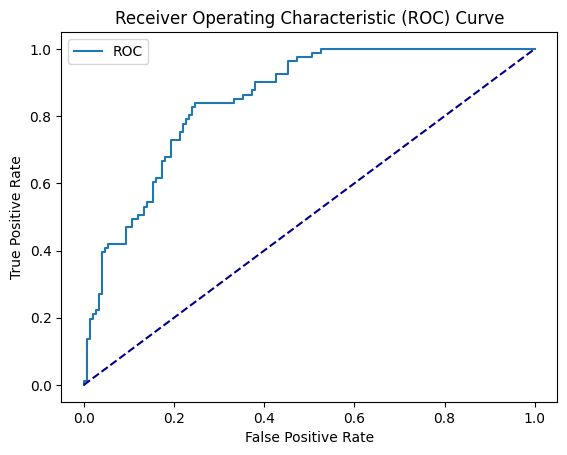

AUC: 0.85


In [26]:
from sklearn import metrics

model = SVC(C=0.1, gamma=0.0001, kernel='linear',probability=True)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

y_probs = model.predict_proba(X_test) #predict_proba gives the probabilities for the target (0 and 1 in your case)

fpr, tpr, thresholds=metrics.roc_curve(y_test,  y_probs[:,1])

import matplotlib.pyplot as plt
plt.plot(fpr, tpr, label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

auc = metrics.roc_auc_score(y_test, y_probs[:,1])
print('AUC: %.2f' % auc)

### One final word: remember, Bagging and Boosting methods are not restricted to trees for weak learners!

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from matplotlib.colors import ListedColormap

# Assume X, y are already defined in the notebook
# Apply t-SNE with 2 components
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# Encode labels if they are not numeric
if not np.issubdtype(y.dtype, np.number):
    y = LabelEncoder().fit_transform(y)

# Train SVM on t-SNE transformed data
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_tsne, y)

# Create mesh grid for background coloring
h = .02  # Step size in the mesh
x_min, x_max = X_tsne[:, 0].min() - 1, X_tsne[:, 0].max() + 1
y_min, y_max = X_tsne[:, 1].min() - 1, X_tsne[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Predict probability for each point in the grid
Z = svm.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)

# Plot the results
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap="coolwarm")

# Scatter plot of t-SNE data points colored by ground truth labels
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap="coolwarm", edgecolor='k')
plt.colorbar(scatter)
plt.title("t-SNE + SVM Decision Surface")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()
